In [1]:
import os
import argparse
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from utils import preprocess_data, SequenceDataset, train_model, score_model, log, get_predictions, plot_predictions
from model import LSTMRegression

In [4]:
forecast_lead=0
batch_size=32
sequence_length=30
learning_rate = 5e-5
num_hidden_units=16
num_layers=1
dropout=0
num_epochs=2

In [2]:
df = pd.read_parquet("../data/mta_subway_221231_100wk_dbscan.parquet")
df = df.drop(
    [
        "KEW GARDENS_ent", 
        "KEW GARDENS_ex", 
        "15 ST-PROSPECT_ent", 
        "15 ST-PROSPECT_ex", 
        "161/YANKEE STAD_ent",
        "161/YANKEE STAD_ex"
        ],
    axis=1)
df = df.fillna(0)
df.shape

(16800, 752)

In [5]:
df_train, df_test, features = preprocess_data(
        df,
        #target_feature, 
        forecast_lead=forecast_lead,
        train_test_split=0.8
        )

In [10]:
df_test.max().sort_values(ascending=False)

JFK JAMAICA CT1_ent    25050.295740
ATL AV-BARCLAY_ex       1819.215414
ATL AV-BARCLAY_ent      1275.062639
JFK JAMAICA CT1_ex      1136.226094
LORIMER ST_ex            667.241890
                           ...     
121 ST_ex                 -0.052161
121 ST_ent                -0.055217
NEWARK C_ent              -0.066150
TWENTY THIRD ST_ex        -0.101680
ST. GEORGE_ent            -0.130241
Length: 752, dtype: float64

<AxesSubplot:xlabel='TIME'>

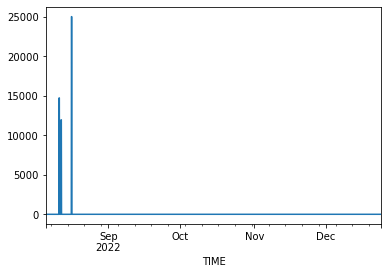

In [12]:
df_test['JFK JAMAICA CT1_ent'].plot()

<AxesSubplot:xlabel='TIME'>

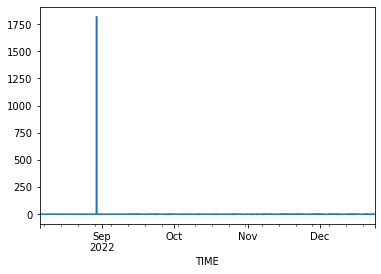

In [13]:
df_test['ATL AV-BARCLAY_ex'].plot()